In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Cleaning of the dataset

We clean both origen and testear.

In [5]:
origen=pd.read_csv("D:/fanny/Documents/cours/ITBA/analisis predictivo/origen.csv")
testear=pd.read_csv("D:/fanny/Documents/cours/ITBA/analisis predictivo/testear.csv")
origen = origen.set_index("Unnamed: 0")
testear = testear.set_index("Unnamed: 0")
origen

,averageRating,numVotes,titleType,isAdult,startYear,endYear,runtimeMinutes,genres_x,directors,writers,...,genres_y,original_language,popularity,production_companies,production_countries,revenue,runtime,status,tagline,video
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,4.4,15,movie,0.0,1951,0,91,"Comedy,Musical",nm0883334,"nm0844784,nm0305863",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.0,990,tvSeries,0.0,2007,2021,30,"Action,Adventure,Animation","nm2291816,nm3088555,nm4930005,nm1746040","nm1707665,nm0789712,nm0403945,nm1826186,nm0630...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.1,41,tvEpisode,0.0,2011,0,44,"Documentary,History,War",nm0414025,"nm0414025,nm3692091,nm1620376",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.6,48,movie,0.0,1969,0,84,Drama,nm2977268,"nm2977268,nm0415515",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.6,28,movie,0.0,2010,0,130,"Comedy,Drama",nm2366663,"nm4290500,nm4289029",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977536,7.4,16,short,0.0,1962,0,0,"Animation,Short",nm0215126,nm0215126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
977537,6.6,2373,movie,0.0,1962,0,109,"Comedy,Musical,Romance",nm0235066,"nm0496468,nm0456487,nm0712029",...,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",en,1.127826,"[{'name': 'The Mirisch Corporation', 'id': 219}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,109.0,Released,NaN,False
977538,7.6,41,tvEpisode,0.0,2000,0,0,"Biography,Documentary",0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing values

In [6]:
#Count the missing values in each variable
origen.isna().sum()

averageRating                0
numVotes                     0
titleType                    0
isAdult                      0
startYear                    0
endYear                      0
runtimeMinutes               0
genres_x                     2
directors                    0
writers                      0
seasonNumber            539298
episodeNumber           539298
ordering                606918
language                606918
attributes              606918
isOriginalTitle         606918
adult                   930171
budget                  930171
genres_y                930171
original_language       930183
popularity              930172
production_companies    930172
production_countries    930172
revenue                 930172
runtime                 930383
status                  930242
tagline                 953696
video                   930172
dtype: int64

In [7]:
print(origen['titleType'].unique())

['movie' 'tvSeries' 'tvEpisode' 'short' 'video' 'tvSpecial' 'tvMovie'
 'tvMiniSeries' 'videoGame' 'tvShort']


We start by considering that if we don't have the season number or episode number, then for the categories "movie", "video", "tvSpecial", "tvMovie" and "videoGame" we have 0 season and 1 episode, then for the other categories we put 1 season and the median of the number of episodes where we have only one season in the dataset.

In [45]:
# We compute the median of 'episodeNumber' when 'seasonNumber' is equal to 1
oneseason=origen[origen['seasonNumber']==1]
median=oneseason["episodeNumber"].dropna().median()
print(f"median for origen: {median}")

oneseasont=testear[testear['seasonNumber']==1]
mediant=oneseasont["episodeNumber"].dropna().median()
print(f"median for testear: {mediant}")

median for origen: 7.0
median for testear: 7.0


In [46]:
# Fonction to replace NaN in episodeNumber and seasonNumber
def replace_nan_episode(row):
    if pd.isna(row['episodeNumber']): 
        if row['titleType'] in ['movie', 'video', 'tvSpecial', 'tvMovie', 'videoGame']:        
            return 1
        else:
            return 7
    else:
        return row['episodeNumber']

def replace_nan_season(row):
    if pd.isna(row['seasonNumber']): 
        if row['titleType'] in ['movie', 'video', 'tvSpecial', 'tvMovie', 'videoGame']:        
            return 0
        else:
            return 1
    else:
        return row['seasonNumber']

# We apply the fonctions
origen['episodeNumber'] = origen.apply(replace_nan_episode, axis=1)
origen['seasonNumber'] = origen.apply(replace_nan_season, axis=1)

testear['episodeNumber'] = testear.apply(replace_nan_episode, axis=1)
testear['seasonNumber'] = testear.apply(replace_nan_season, axis=1)

# check if there is any NaN left
print(origen[['episodeNumber','seasonNumber']].isna().sum())
print(testear[['episodeNumber','seasonNumber']].isna().sum())

episodeNumber    0
seasonNumber     0
dtype: int64
episodeNumber    0
seasonNumber     0
dtype: int64


For 'ordering', I replace the NaN by the mean.

In [47]:
#origen
mean_ordering=int(origen['ordering'].mean())
origen['ordering'].fillna(mean_ordering, inplace=True)

#testear
mean_orderingt=int(testear['ordering'].mean())
testear['ordering'].fillna(mean_orderingt, inplace=True)

For directors and writers, we have an issue when there are two or more for one row, so we decide to just keep the first.

In [48]:
columns = ['directors', 'writers']

for column in columns:
    origen[column] = origen[column].str.lstrip('nm')
    origen[column] = origen[column].str.split(',').str[0]
    
    testear[column] = testear[column].str.lstrip('nm')
    testear[column] = testear[column].str.split(',').str[0]

I am now deleting the 2 rows where genres_x = NaN.

In [49]:
origen = origen.dropna(subset=['genres_x'])
testear= testear.dropna(subset=['genres_x'])

For the rest of the columns with missing values, I won't consider them because there are too many missing values and I can't replace them.

In [50]:
origen2=origen[['averageRating','numVotes','titleType','isAdult','startYear','endYear','runtimeMinutes','genres_x','directors','writers',
                'seasonNumber','episodeNumber','ordering']]
testear2=testear[['numVotes','titleType','isAdult','startYear','endYear','runtimeMinutes','genres_x','directors','writers',
                'seasonNumber','episodeNumber','ordering']]
origen2.head()

,averageRating,numVotes,titleType,isAdult,startYear,endYear,runtimeMinutes,genres_x,directors,writers,seasonNumber,episodeNumber,ordering
Unnamed: 0,,,,,,,,,,,,,
0,4.4,15,movie,0.0,1951,0,91,"Comedy,Musical",0883334,0844784,0.0,1.0,3.0
1,7.0,990,tvSeries,0.0,2007,2021,30,"Action,Adventure,Animation",2291816,1707665,1.0,7.0,5.0
2,8.1,41,tvEpisode,0.0,2011,0,44,"Documentary,History,War",0414025,0414025,1.0,5.0,3.0
3,4.6,48,movie,0.0,1969,0,84,Drama,2977268,2977268,0.0,1.0,5.0
4,5.6,28,movie,0.0,2010,0,130,"Comedy,Drama",2366663,4290500,0.0,1.0,3.0


### Outliers

We search for outliers only in numerical values.

In [51]:
origen2.describe()

,averageRating,numVotes,isAdult,startYear,endYear,runtimeMinutes,seasonNumber,episodeNumber,ordering
count,977539.000000,9.775390e+05,977539.000000,977539.000000,977539.000000,977539.000000,977539.000000,977539.000000,977539.000000
mean,6.881762,1.625624e+03,0.018890,1999.360241,58.196832,41.363706,2.013643,26.519635,3.181765
std,1.405316,2.509801e+04,0.136138,34.243116,336.455362,57.788836,8.471148,392.919380,3.178621
min,1.000000,5.000000e+00,0.000000,0.000000,0.000000,-22336.000000,0.000000,0.000000,1.000000
25%,6.100000,9.000000e+00,0.000000,1992.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,7.100000,2.200000e+01,0.000000,2008.000000,0.000000,27.000000,1.000000,5.000000,3.000000
75%,7.900000,9.300000e+01,0.000000,2015.000000,0.000000,73.000000,2.000000,7.000000,3.000000
max,10.000000,2.425542e+06,1.000000,2021.000000,2022.000000,13319.000000,2012.000000,15762.000000,162.000000


We start with 'endYear'. We consider that when endYear = 0 and startYear<>0, then endYear = startYear.

In [ ]:
origen2['endYear'] = np.where(origen2['endYear'] == 0, origen2['startYear'], origen2['endYear'])
testear2['endYear'] = np.where(testear2['endYear'] == 0, testear2['startYear'], testear2['endYear'])
origen2.describe()

# Model

In [52]:
# Searching for categorical variable
print(origen2.dtypes)

averageRating     float64
numVotes            int64
titleType          object
isAdult           float64
startYear           int64
endYear             int64
runtimeMinutes      int64
genres_x           object
directors          object
writers            object
seasonNumber      float64
episodeNumber     float64
ordering          float64
dtype: object


We separate X, a matrix containing all the variables except for the response variable, and y, a vector containing the response variable.

In [53]:
# Select the desired columns for prediction
X=origen2[['numVotes','titleType','isAdult','startYear','endYear','runtimeMinutes', 'genres_x', 'directors', 'writers',
                'seasonNumber','episodeNumber','ordering']]

X_testear = testear2[['numVotes','titleType','isAdult','startYear','endYear','runtimeMinutes', 'genres_x','directors','writers', 
                'seasonNumber','episodeNumber','ordering']]

# Select the target variable 'averageRatings'
y = origen2['averageRating']

We now encode the categorical variables.

In [54]:
# Encoding of titleType
X = pd.get_dummies(X, columns=['titleType'], prefix=['titleType'])
X_testear = pd.get_dummies(X_testear, columns=['titleType'], prefix=['titleType'])

# Encoding of genres_x
X['genres_x'] = X['genres_x'].str.split(',')
X_testear['genres_x'] = X_testear['genres_x'].str.split(',')

unique_genres = set(genre for genres in X['genres_x'] for genre in genres)
for genre in unique_genres:
    X[genre] = X['genres_x'].apply(lambda genres: 1 if genre in genres else 0)
    X_testear[genre] = X_testear['genres_x'].apply(lambda genres: 1 if genre in genres else 0)
    
X.drop('genres_x', axis=1, inplace=True)   
X_testear.drop('genres_x', axis=1, inplace=True)


### Random Forest

In [55]:
X_rf =X
X_rf_testear = X_testear
y_rf =y

# Split the data into training and testing sets
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

We use GridSearchCv to find the best combination of parameters.

In [ ]:
model_rf = RandomForestRegressor(random_state=42)


# Define the grid for the paramaters to explore
param_grid = {
    'n_estimators': [150],
    'max_depth': [None,30,35,40]

}


grid_search = GridSearchCV(model_rf, param_grid, cv=4, scoring='neg_mean_squared_error')
grid_search.fit(X_rf_train, y_rf_train)


# Print the best parameters
best_params = grid_search.best_params_
print(f"Best parameters : {best_params}")



# Make predictions on X_test with the best parameters
y_rf_pred = grid_search.best_estimator_.predict(X_rf_test)

# Evaluate the model performance
mse_rf = mean_squared_error(y_rf_test, y_rf_pred)
r2_rf = r2_score(y_rf_test, y_rf_pred)

print(f"Mean Squared Error: {mse_rf}")
print(f"R-squared: {r2_rf}")

We then apply these parameters on our model.

In [56]:
temps_debut = time.time()

model_rf = RandomForestRegressor(n_estimators=150, max_depth=35,random_state=42)
model_rf.fit(X_rf_train, y_rf_train)

# Fais des prédictions sur les données de test
y_rf_pred = model_rf.predict(X_rf_test)

# Évalue les performances du modèle
mse_rf = mean_squared_error(y_rf_test, y_rf_pred)
r2_rf = r2_score(y_rf_test, y_rf_pred)

temps_fin = time.time()

# Calculez la différence pour obtenir le temps d'exécution
temps_execution = temps_fin - temps_debut

print("Le temps d'exécution est de", temps_execution, "secondes.")

print(f"Mean Squared Error: {mse_rf}")
print(f"R-squared: {r2_rf}")

Le temps d'exécution est de 2139.022323846817 secondes.
Mean Squared Error: 0.9926968089427708
R-squared: 0.4957811915039373


We then use the model on the dataset testear.

In [57]:
# Predict using the trained model
y_pred_other_rf = model_rf.predict(X_rf_testear)
# Print the predictions for the other data
print("Predictions for other data:")
print(y_pred_other_rf)

Yest_rf = model_rf.predict(X_rf_testear)

Predictions for other data:
[7.51272715 7.38680082 6.14083157 ... 5.83533333 7.22814372 5.00966667]


Download the file for the submission.

In [58]:
sol_rf = pd.DataFrame(data={"averageRating": Yest_rf}).astype(str)
sol_rf.index = testear2.index
sol_rf.to_csv("submission7.csv", sep=',',index=True,  index_label='Id')
sol_rf

,averageRating
Unnamed: 0,
0,7.512727151160825
1,7.386800820494116
2,6.140831568249762
3,7.827799873737368
4,7.50068898109297
...,...
244381,7.107973100850034
244382,6.667777777777776
244383,5.835333333333332


In [59]:
y_rf_test.to_frame()
y_rf_pred= pd.DataFrame(y_rf_pred,columns=['averageRating'])
y_rf_pred=y_rf_pred.set_index(y_rf_test.index)
y_rf_pred=y_rf_pred.reset_index()
y_rf_test=y_rf_test.reset_index()
y_rf_pred

,Unnamed: 0,averageRating
0,601163,5.916714
1,205116,5.245333
2,218398,7.206210
3,20090,7.471733
4,512513,6.740611
...,...,...
195503,441485,7.697768
195504,64924,7.767949
195505,811715,5.106000
195506,743884,5.375665


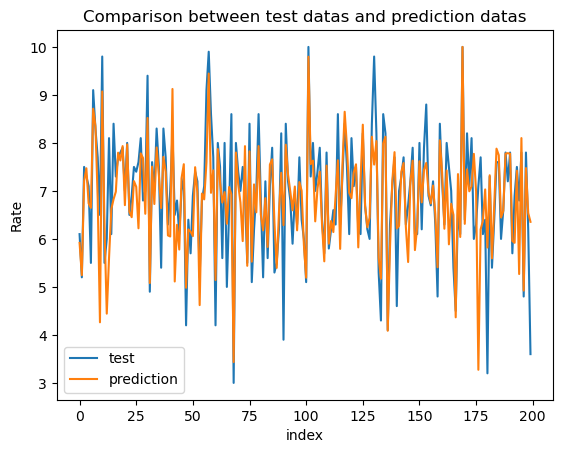

In [60]:
plt.plot(y_rf_test['averageRating'].head(200), label='test')
plt.plot(y_rf_pred['averageRating'].head(200), label='prediction')
plt.legend()
plt.title('Comparison between test datas and prediction datas')
plt.xlabel('index')
plt.ylabel('Rate')
plt.show()